In [5]:
import sys
sys.path
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [6]:
import csv
import cv2
import os
import re
import pandas as pd
import keras
import numpy as np
import featexp as fe
import random
import glob
import tensorflow as tf
import tensorflow_probability as tfd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Input, Activation
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D,merge
from keras.layers.pooling import MaxPooling2D
from keras.utils import plot_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import TensorBoard
from scipy.stats import multivariate_normal
from keras.models import Model
from keras import backend as K
from keras import losses
from sklearn.mixture import GaussianMixture
from tensorflow.keras import layers
from keras.layers import Layer, interfaces, activations, initializers, regularizers, constraints
from keras.engine.base_layer import InputSpec
from keras.optimizers import Adam
from PIL import Image


Using TensorFlow backend.


### read matched log info

In [7]:
log = pd.read_csv('match_0807.csv')
#our final target is curvature which is generated by speed divided by angular velocity
log['curvature'] = 0
curv = []
for i in range(len(log)):
    try:
        curv.append(log['angular_velocity'].iloc[i] / log['speed'].iloc[i])
    except ValueError:
        curv.append(0)
for i in range(len(log)):
    if curv[i] > 1 or curv[i] < -1:
        curv[i] = 0
log['curvature'] = curv
log = log.fillna(0)
measurement = log['curvature']
print(len(log))
log.head()

1967


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


,Unnamed: 0,frame_id_forward,time,frame_id_left,latitude,longitude,speed,heading,angular_velocity,curvature
0,1853,15,1565158633,64,31.181093,121.600885,0.0,3.006155,0.0048,0.0
1,1854,25,1565158634,82,31.181093,121.600885,0.0,3.006155,0.0054,0.0
2,1855,36,1565158635,99,31.181093,121.600885,0.0,3.006155,0.0046,0.0
3,1856,45,1565158636,115,31.181093,121.600885,0.0,3.006155,0.0054,0.0
4,1857,55,1565158637,132,31.181093,121.600885,0.0,3.006155,0.0050,0.0


### data generator

In [8]:
class DataGenerator(keras.utils.Sequence):
#     generates data for Keras
#     specify 5 inputs' folder and set batch size for each loading
    def __init__(self, f_cam_folder, l_cam_folder, r_cam_folder, umap_folder, rmap_folder, 
                 labels = None, batch_size=8, shuffle=True):
        self.batch_size = batch_size
        self.f_cam_folder = f_cam_folder
        self.l_cam_folder = l_cam_folder
        self.r_cam_folder = r_cam_folder
        self.umap_folder = umap_folder
        self.rmap_folder = rmap_folder
        self.labels = labels
        self.shuffle = shuffle
        self.df = log.values[330:]
        self.on_epoch_end()

    def __len__(self):
#         Denotes the number of batches per epoch
        return int(np.floor(len(self.df) / self.batch_size))

    def __data_generation(self, idx):
#         Generates data containing batch_size samples
        # Generate data
        f_img_name = os.path.join(self.f_cam_folder, 'frame_vc1_'+str(int(self.df[idx - 1][1]))+'.bmp')
        l_img_name = os.path.join(self.l_cam_folder, 'frame_vc6_'+str(int(self.df[idx - 1][3]))+'.bmp')
        r_img_name = os.path.join(self.r_cam_folder, 'frame_vc5_'+str(int(self.df[idx - 1][3]))+'.bmp')
        umap_name = os.path.join(self.umap_folder, str(int(self.df[idx - 1][2]))+'.png')
        rmap_name = os.path.join(self.rmap_folder, str(int(self.df[idx - 1][2]))+'.png')
        labels = self.labels[idx]
        name = [f_img_name, l_img_name, r_img_name, umap_name, rmap_name]
        images = [0 for _ in range(5)]
        region = (0,200,640,402)
        
        for i in range(5):
            image = Image.open(name[i]).convert('RGB')
            if i <= 2:
                images[i] = image.crop(region).resize((200, 80))

            else:
                if i == 3:
                    images[i] = Image.open(name[i]).convert('1').resize((50, 50))
                if i == 4:
                    images[i] = image.resize((50, 50))
                

        return [images[0], images[1],images[2],images[3],images[4]], labels


    def __getitem__(self, index):
#         Generate one batch of data

        # Generate data
        X = self.__data_generation(index)

        return X

    def on_epoch_end(self):
#         Updates indexes after each epoch
        self.indexes = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    

In [10]:
path = "/media/yang/361641d9-fb7d-4447-a97a-673ae511c6d4/user/data/0807/"

# Parameters
params = {
            'f_cam_folder': path + 'forward_compressed/', 
            'l_cam_folder': path + 'left_compressed/', 
            'r_cam_folder': path + 'right_compressed/', 
            'umap_folder': path + 'unrouted_map/', 
            'rmap_folder': path + 'routed_map/', 
            'labels':  measurement, 
            'batch_size': 4,
            'shuffle': True
            }


# Generators
training_generator = DataGenerator(**params)
# validation_generator = DataGenerator(**params)


In [7]:
tb = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=1,  # 按照何等频率（epoch）来计算直方图，0为不计算
                 batch_size=32,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=False,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)
callbacks = [tb]


In [55]:
def gmm_loss(y_true, y_pred):
"""
    total loss for model
    args:
        y_true: value of label
        y_pred: related prediction
    returns:
        total loss which consists of cross-entrophy of N normal distributions,
        normalization of weight and variance,
        and MSE of curvature
"""
# c: regularization constant for variance term
# c0: coeffecient for variance in normal distribution
    c = 0.05
    c0 = 0.1

# use FC layers to simulate GMM

#     y_true = y_true * tf.ones(y_pred.shape)
#     phi, mu, sigma_new = y_pred[:,0:3], y_pred[:,3:6], y_pred[:,6:9]
    phi, mu = y_pred[:,0:3], y_pred[:,3:6]

    y = y_true * tf.ones(tf.shape(mu), dtype = tf.dtypes.float32)

    sigma_new = tf.ones(tf.shape(mu), dtype=tf.dtypes.float32)
    dist = tfd.distributions.Normal(loc = mu, scale = c0*sigma_new)

    fs = tf.reduce_sum(tf.multiply(phi, exp(tf.log(dist.prob(y)))), 1) 
    return -K.sum(tf.multiply(y_true, tf.log(abs(fs)))) + tf.norm(phi, ord = 2) + losses.mean_squared_error(y_true, y_pred) + tf.norm(tf.log(abs(sigma_new)) - c, ord =2)



In [9]:
"""
    activation for variance output
"""
def exp(x):
    return K.exp(x)

In [ ]:
"""
    normalization for camera images
"""
def normal(x):
    return x/255

In [1]:
# set input shape for all images 
camera_image = training_generator.__getitem__(1)[0]
forward_images = camera_image[0]
left_images = camera_image[1]
right_images = camera_image[2]
unrouted_map = camera_image[3]
routed_map = camera_image[4]


input_shape_forward = np.array(forward_images).shape
input_shape_left = np.array(left_images).shape
input_shape_right = np.array(right_images).shape
input_shape_routed_map = np.array(routed_map).shape
input_shape_unrouted_map = np.array(unrouted_map).shape

NameError: name 'training_generator' is not defined

In [11]:
"""
    model for end-to-end pipline
    args:
        all 5 inputs from camera images and maps
    returns:
        model
"""
def model_e2e(input_forward, input_left, input_right, input_unrouted_map, input_routed_map):
    input_forward = Input(shape=input_shape_forward)
    input_left = Input(shape=input_shape_left)
    input_right = Input(shape=input_shape_right)
    input_unrouted_map = Input(shape=(50, 50, 1))
    input_routed_map = Input(shape=input_shape_routed_map)
    
    model_forward = Conv2D(24, (5, 5), strides=(2,2), padding='same', activation='relu')(input_forward)
    model_forward = Conv2D(36, (5, 5), strides=(2,2), padding='same', activation='relu')(model_forward)
    model_forward = Conv2D(48, (3, 3), strides=(2,2), padding='same', activation='relu')(model_forward)
    model_forward = Conv2D(64, (3, 3), strides=(1,1), padding='same', activation='relu')(model_forward)
    model_forward = Flatten()(model_forward)

    model_left = Conv2D(24, (5, 5), strides=(2,2), padding='same', activation='relu')(input_left)
    model_left = Conv2D(36, (5, 5), strides=(2,2), padding='same', activation='relu')(model_left)
    model_left = Conv2D(48, (3, 3), strides=(2,2), padding='same', activation='relu')(model_left)
    model_left = Conv2D(64, (3, 3), strides=(1,1), padding='same', activation='relu')(model_left)
    model_left = Flatten()(model_left)
    
    model_right = Conv2D(24, (5, 5), strides=(2,2), padding='same', activation='relu')(input_right)
    model_right = Conv2D(36, (5, 5), strides=(2,2), padding='same', activation='relu')(model_right)
    model_right = Conv2D(48, (3, 3), strides=(2,2), padding='same', activation='relu')(model_right)
    model_right = Conv2D(64, (3, 3), strides=(1,1), padding='same', activation='relu')(model_right)
    model_right = Flatten()(model_right)
    
    
    model_unrouted_map = Conv2D(24, (5, 5), strides=(2,2), padding='same', activation='relu')(input_unrouted_map)
    model_unrouted_map = Conv2D(36, (5, 5), strides=(2,2), padding='same', activation='relu')(model_unrouted_map)
    model_unrouted_map = Conv2D(48, (3, 3), strides=(2,2), padding='same', activation='relu')(model_unrouted_map)
    model_unrouted_map = Flatten()(model_unrouted_map)
    
    
    output_img = concatenate([model_forward, model_left, model_right, model_unrouted_map], axis=1)
#     output_img = model_unrouted_map

    p1 = Dense(1000, activation='relu')(output_img)
    p1 = Dense(100, activation='relu')(p1)
    weight = Dense(3, activation='softmax')(p1)
    mean = Dense(3, activation='linear')(p1)
    var = Dense(3, activation=exp)(p1)
    
#     print(res)
    model_routed_map = Conv2D(24, (5, 5), strides=(2,2), padding='same', activation='relu')(input_routed_map)
    model_routed_map = Conv2D(36, (5, 5), strides=(2,2), padding='same', activation='relu')(model_routed_map)
    model_routed_map = Flatten()(model_routed_map)
    
    output_comb = concatenate([p1, model_routed_map], axis=1)
    p2 = Dense(100, activation='relu')(output_comb)
    curv = Dense(1, activation='linear')(p2)
#     res = concatenate([weight, mean, carv], axis = 1)
    res = concatenate([weight, mean, var, curv], axis = 1)

    model = Model(inputs = [input_forward, input_left,input_right, input_unrouted_map, input_routed_map], outputs = res)
#     model.summary()
    
    return model


In [56]:
# training process
epochs = 3
for e in range(epochs):
    print('Epoch', e)
    batches = 0
#     initial lists for holding data from datagenerator
    fl = []
    ll = []
    rl = []
    uml = []
    rml = []
    yl = []
    for x_batch, y_batch in training_generator:
        fl.append(np.array(x_batch[0]))
        ll.append(np.array(x_batch[1]))
        rl.append(np.array(x_batch[2]))
        uml.append(np.array(x_batch[3]))
        rml.append(np.array(x_batch[4]))
        yl.append(y_batch)
        batches += 1
        if batches >= len(log / params['batch_size']):
            break
    
    X = [normal(np.array(fl)), normal(np.array(ll)), normal(np.array(rl)), normal(np.array(uml)), normal(np.array(rml))]
    X[3] = X[3].reshape(X[3].shape[0], 50, 50, 1)
    Y = [np.array(yl)]#,np.array(yl),np.array(yl),np.array(yl)]
    
    model = model_e2e(X[0], X[1], X[2], X[3], X[4])
    adam = Adam(lr=1e-6)
    
    print(Y[0][1:5])
    model.compile(optimizer=adam, loss=gmm_loss)
    model.fit(x=X, y=Y, validation_split=0.2, shuffle=True, epochs=10)#, callbacks=callbacks)
        

Epoch 0
[0. 0. 0. 0.]
Train on 327 samples, validate on 82 samples
Epoch 1/10
327/327 [==============================] - 16s 48ms/step - loss: 11.0632 - val_loss: 5.2606
Epoch 2/10
327/327 [==============================] - 11s 34ms/step - loss: 8.7601 - val_loss: 4.7128
Epoch 3/10
327/327 [==============================] - 11s 33ms/step - loss: 5.6795 - val_loss: 3.8777
Epoch 4/10
327/327 [==============================] - 11s 33ms/step - loss: 0.1294 - val_loss: 1.7631
Epoch 5/10
327/327 [==============================] - 11s 32ms/step - loss: -10.3073 - val_loss: -2.2041
Epoch 6/10
 96/327 [=======>......................] - ETA: 7s - loss: -28.8248

KeyboardInterrupt: 

In [57]:
res = model.predict(X)

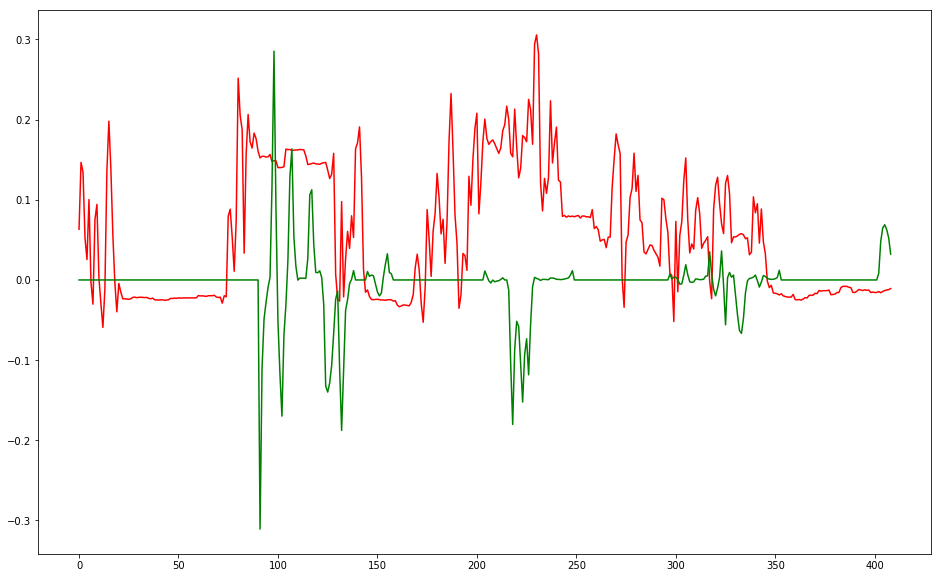

In [58]:
plt.figure(figsize=(16, 10))
plt.plot(res[:,-1], 'r')
plt.plot(Y[0], 'g')

In [59]:
mean_squared_error(Y[0], res[:,-1])

0.012422951186310621

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/media/yang/361641d9-fb7d-4447-a97a-673ae511c6d4/user/data/0624/data/',
        target_size=(80, 200),
        batch_size=32,
        )

In [ ]:
a = train_generator.__getitem__(1)[0][4]
k = cv2.merge([a[:,:,0],a[:,:,1],a[:,:,2]])
plt.imshow(k)
